In [66]:
%matplotlib inline

In [67]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [68]:
# imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import imutils
import ipyplot

In [69]:
CONTOURCOLOR = (0,100,0)
BOXCOLOR = (150,0,0)

In [70]:
#####utility functions for all cells######


'''
display images in jupyter notebook
'''
def displayImage(image, imgname=None):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    if imgname:
        plt.savefig(imgname, bbox_inches="tight", pad_inches = 0)
        
'''
check function to display an information to make opencv error more transparent
'''
def is_8UC1(image):
    if len(np.shape(image)) > 2:
        print("Color channel detected. Are you sure input is a grayscale image?")
        return False
    return True

'''
Use to load image by URL or file path
'''
def loadImage(filepath, resize_width = 0):
    
    if filepath.startswith("http"):
        image = imutils.url_to_image(filepath)
    else:
        #check if input file exists
        if not os.path.isfile(filepath):
            raise FileNotFoundError("Input file could not be read. Please check your file path.")
        image = cv2.imread(filepath)
    #check if opencv was successful reading the image
    if image is None:
        raise ValueError("Input file exists but could not be read by opencv (probably not a valid image).")
    
    height, width, _ = image.shape
    if resize_width and width > resize_width:
        scale = resize_width / width
        newHeight = height * scale
        image = cv2.resize(image,(resize_width, int(newHeight)))
    return image

'''
utility wrapper for plotting of lists of cv2 image formats
'''
def plotImgList(images):
    ipyplot.plot_images([cv2.cvtColor(x, cv2.COLOR_BGR2RGB) for x in images], img_width=250)   

# Image Segmentation with Mathematical Morphology

In [71]:
#####core concept of contour based image segmentation####

'''
Method to find and draw contours on the current image.
Contour finding is applied on the foreground (= BRIGHT areas)

currentImage: image to calculate contours on
origImage: image to draw contours on (should be the original image in color for contours to have color)
area_threshold: only return contours above a relative area of the image
'''
def findAndDrawContours(currentImage, origImage, area_threshold = 0.1):
    is_8UC1(currentImage)
    
    contours, _ = cv2.findContours(currentImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contoursImg = origImage.copy()
    
    if area_threshold: #only draw largest contours
        contoursToDraw = [c for c in contours if currentImage.shape[0]*currentImage.shape[1]*area_threshold <= cv2.contourArea(c)]
    else:
        contoursToDraw = contours
        
    cv2.drawContours(contoursImg, contoursToDraw, -1, CONTOURCOLOR, thickness=cv2.FILLED)
    return contoursToDraw, contoursImg

'''
draws a bounding box around every provided contour (and fills it for better visibility)
image: image to draw boxes on
contours: contour results returned by find contour function
area_threshold: only draw boxes above a relative area of the image
'''
def drawBoxes(image, contours, area_threshold = 0.1):
    
    boxImg = image.copy()
    for contour in contours:
        if area_threshold:
            if image.shape[0]*image.shape[1]*area_threshold > cv2.contourArea(contour):
                continue
        (x,y,width,height) = cv2.boundingRect(contour)
        cv2.rectangle(boxImg, (x,y), (x+width, y+height), BOXCOLOR, thickness=cv2.FILLED)
    #cv2.drawContours(boxImg, boxes, -1, BOXCOLOR, thickness=cv2.FILLED)
    return boxImg

In [72]:
###simplified functions to apply mathematical morphology operations on images

'''
Converts a color image to a grayscale image
'''
def convertToGray(image):
    grayImg = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return grayImg

'''
Converts a grayscale image to a black and white image
'''
def binarizeImg(image):
    is_8UC1(image)
    
    _,binaryImg = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return binaryImg

'''
Applies a blurring filter to the image, making edges smoother
params = pixel diameter and sigma values. In general: larger values create stronger blurring
'''
def blurImg(image, params = (15,10,10)):
    blurredImg = cv2.bilateralFilter(image, *params)
    return blurredImg

'''
Applying dilation to an image, making edges wider
Dilation is applied on the foreground (= BRIGHT areas)
'''
def dilateImg(image, kernelsize = (2,2)):
    #NOTE: Larger kernel corrects breaks in contour lines better but makes segmentation of text more likely
    KERNEL_SIZE_DIL = kernelsize

    kernel = np.ones(KERNEL_SIZE_DIL, np.uint8)
    dilatedImg = cv2.dilate(image, kernel, iterations=1)
    return dilatedImg

def apply_blacktophat(image, kernelsize = (20,20)):
    is_8UC1(image)
    
    KERNEL_FORM_B = cv2.MORPH_ELLIPSE
    KERNEL_SIZE_B = kernelsize

    kernel = cv2.getStructuringElement(KERNEL_FORM_B, KERNEL_SIZE_B)
    blackhat_inverted = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)    
    return blackhat_inverted

'''
Inverts color of every pixel of an image
'''
def invertImg(image):
    return cv2.bitwise_not(image)

## Exercise 0: Use image operations

If you are not familiar with the given image operations, it might be helpful to apply them to the input image and to display the result. For some of the simplified functions you can adjust the parameters and check the different results.

In [ ]:
'''
INSERT CODE TO PLAY AROUND WITH MORPHOLOGY FUNCTIONS 
'''

## Exercise 1: Find a operation chain for image segmentation

We want to segment the image so that the illustration is found and the rest is discarded. We do this by contour detection with opencv. You can use the function `findAndDrawContours` in this notebook.
However, to work properly, the image has to be run through a chain of morphological operations. It is your goal to find an appropriate operation to segment the illustration in the sample image

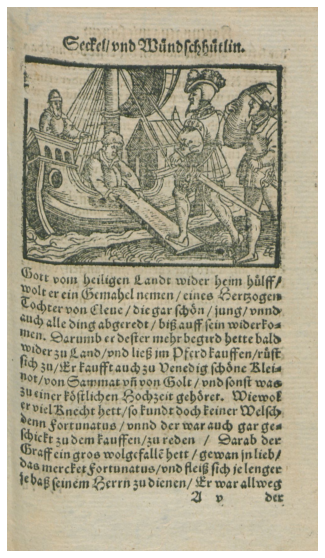

In [73]:
#load image for segmentation

FILE_PATH = "https://content.staatsbibliothek-berlin.de/dc/846323621-0013/50,70,1000,1750/full/0/default.jpg"

image = loadImage(FILE_PATH)
    
displayImage(image)

To follow the path of the image through the operations, I recommend to create an explicit 'operation chain', to which the image is appended after every step. The final step is the contour find. 
Contours are filled with their color (green) for better visibility.
Afterwards the contours can be simplified into bounding boxes (filled by their color, blue).

For simplicity purposes, only contours above an area threshold are displayed (default: 0.1), since illustrations are expected to be above a certain size on a book page.

Since many operations can only be done on grayscale images, this is -- spoiler -- the first step of the operation chain


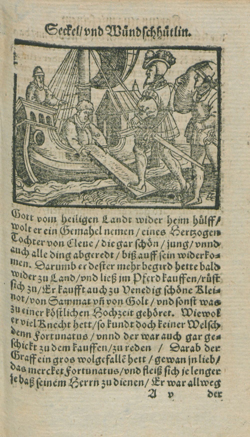
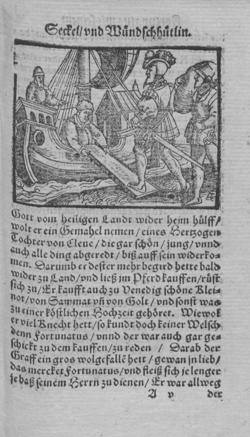
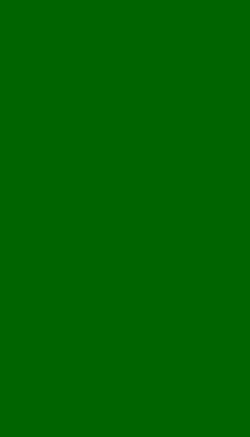


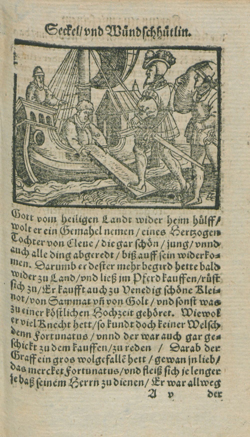
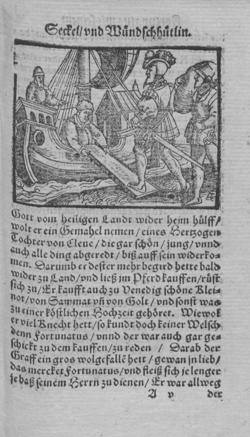
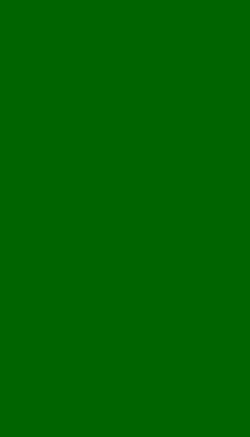

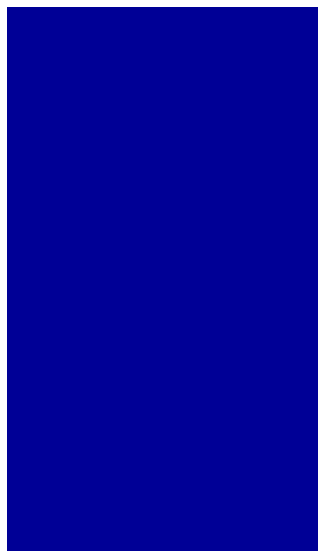

In [74]:
operationChain = [image] #start chain with input image

#convert last element of chain to gray scale and append
operationChain.append(convertToGray(operationChain[-1]))

#find contours in last element of chain and append
cont, contImg = findAndDrawContours(operationChain[-1], image)
operationChain.append(contImg)

#plot the completed chain
plotImgList(operationChain)

#draw bounding boxes on last element of chain and display
displayImage(drawBoxes(operationChain[-1], cont))

As one can see, the proposed chain does not work properly, since the full image is detected as illustration area.

### Task: add other operations to the chain to segment the image

In [ ]:
#Lets try once more ...

operationChain = [image] #start chain with input image

#convert last element of chain to gray scale and append
operationChain.append(convertToGray(operationChain[-1]))

'''
INSERT CODE TO MAKE OPERATION CHAIN 
'''

#find contours in last element of chain and append
cont, contImg = findAndDrawContours(operationChain[-1], image)
operationChain.append(contImg)

#plot the completed chain
plotImgList(operationChain)

#draw bounding boxes on last element of chain and display
displayImage(drawBoxes(operationChain[-1], cont))

## Exercise 2: Check for robustness

Hopefully, you have found a working operation chain for exercise 1. If not, please ask your session instructor before you continue.

In the first example, the IIIF image has been cropped to only show the page content. In reality, books are often digitized with background around the page.
Try your operation chain for exercise one on the new input `img2`

In [ ]:
img2 = loadImage("https://content.staatsbibliothek-berlin.de/dc/846323621-0013/full/full/0/default.jpg")

'''
INSERT CODE TO TRY YOUR OPERATION CHAIN ON img2
'''

If your operation chain fails on `img2`, try to adapt it to the new problem. Once you have found a valid solution, do not forget to try on the first image again or on other images of your choice